# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнил: Леу Иван Александрович
###### Группа: М8О-309Б-23
###### Датасет (ссылка): [Медицинские коляски](https://www.kaggle.com/datasets/jaderz/hospital-beds-management/data)

---

# Выбор модели и ее гиперпараметры

Для выполнения лабораторной работы была выбрана модель Random Forest - ансамблевый метод машинного обучения, основанный на построении множества решающих деревьев и усреднении их результат

| Гиперпараметр       | Тип            | Описание                              | Возможные значения                     |
|---------------------|----------------|----------------------------------------|----------------------------------------|
| `n_estimators`      | `int`          | Количество деревьев в лесу             | `100`, `200`, `300`, `500`             |
| `max_depth`         | `int` или `None` | Максимальная глубина каждого дерева    | `5`, `10`, `15`, `20`, `None`          |
| `min_samples_split` | `int`          | Минимальное число объектов для разделения узла | `2`, `5`, `10`, `15`             |
| `min_samples_leaf`  | `int`          | Минимальное число объектов в листе     | `1`, `2`, `4`, `8`                     |
| `max_features`      | `str` / `float`| Количество признаков для поиска лучшего разбиения | `'sqrt'`, `'log2'`, `0.3`, `0.5`, `0.8` |
| `bootstrap`         | `bool`         | Использовать ли bootstrap-выборки      | `True`, `False`                        |
| `class_weight`      | `str` / `dict` | Веса классов для балансировки          | `None`, `'balanced'`                   |

# Выбор датасета и подготовка данных

Использован датасет с данными о работе медицинского сервиса. 
Данные содержат следующие признаки:

Признаки: week, month, service, available_beds, patients_request, patients_admitted, patients_refused, patient_satisfaction, staff_morale, event
Целевая переменная: refused_flag (0 - никому, > 0 - хоть одному)

Импортируем необходимые модули и зафиксируем рандом.

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from scipy.stats import randint
import lime
import lime.lime_tabular
import shap
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Загрузим тестовый и для обучения датасеты. Выведем основную информацию о датасетах.

In [38]:
df = pd.read_csv("services_weekly.csv")

df['refused_flag'] = (df['patients_refused'] > 0).astype(int)

print("Размер train:", df.shape)
print("\nКолонки train:", df.columns.tolist())

print("\nРаспределение refused_flag в train:")
print(df['refused_flag'].value_counts())

Размер train: (208, 11)

Колонки train: ['week', 'month', 'service', 'available_beds', 'patients_request', 'patients_admitted', 'patients_refused', 'patient_satisfaction', 'staff_morale', 'event', 'refused_flag']

Распределение refused_flag в train:
refused_flag
1    148
0     60
Name: count, dtype: int64


В целом, деревья устойчивы к ненормализованным данным, но все равно немного подготовим данные и разделим их.

In [39]:
cat_cols = ['service','event']          
num_cols = ['week','month','available_beds','patients_request','patients_admitted','patient_satisfaction','staff_morale']

X_train = df[cat_cols + num_cols]
y_train = df['refused_flag']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')


Визуализируем данные.


2. ВИЗУАЛИЗАЦИЯ ДАННЫХ


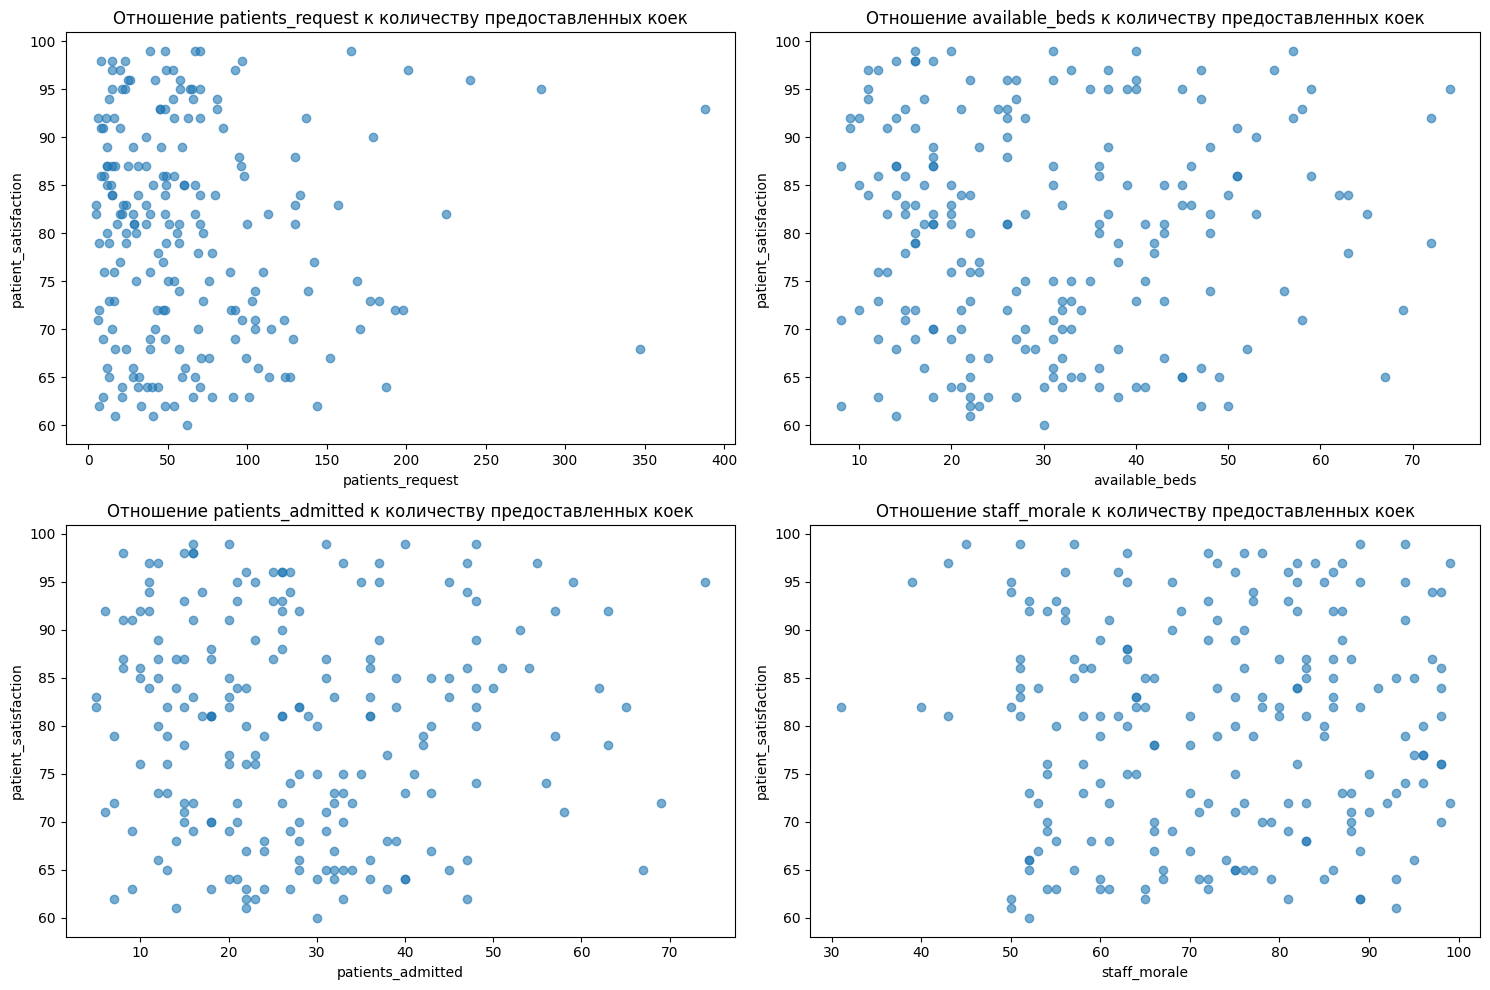

In [40]:
print("\n2. ВИЗУАЛИЗАЦИЯ ДАННЫХ")

plt.figure(figsize=(15, 10))

features = ['patients_request', 'available_beds', 'patients_admitted', 'staff_morale']

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    plt.scatter(df[feature], df['patient_satisfaction'], alpha=0.6)
    plt.title(f'Отношение {feature} к количеству предоставленных коек')
    plt.xlabel(feature)
    plt.ylabel('patient_satisfaction')

plt.tight_layout()
plt.show()

Разобьем на данные для валидации.

In [41]:
print("\n3. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ")

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Train split: {X_train_split.shape}, Validation: {X_val.shape}")


3. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
Train split: (166, 9), Validation: (42, 9)


# Подбор гиперпараметров для модели

Подберем оптимальные параметры для Grig Search.

In [42]:
print("=== GRID SEARCH ===")
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', rf)
])

param_grid = {
    'clf__n_estimators': [50, 100, 150],
    'clf__max_depth': [5, 10, 20, None],
    'clf__min_samples_split': [2, 4, 6, 8],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__criterion': ['gini', 'entropy'],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train_split, y_train_split)

print("Grid Search best params:", grid_search.best_params_)
print("Grid Search best score (CV):", grid_search.best_score_)

y_pred_grid = grid_search.predict(X_val)
f1_grid = f1_score(y_val, y_pred_grid, average='macro')
print(f"Grid Search F1 на validation: {f1_grid:.4f}")

=== GRID SEARCH ===
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Grid Search best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 150}
Grid Search best score (CV): 0.9337970478998298
Grid Search F1 на validation: 0.8250


Подберем оптимальные параметры для Random Search.

In [43]:
print("\n=== RANDOM SEARCH ===")
param_dist = {
    'clf__n_estimators': randint(50, 200),
    'clf__max_depth': [5, 10, 20, None],
    'clf__min_samples_split': randint(2, 10),
    'clf__min_samples_leaf': randint(1, 5),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__criterion': ['gini', 'entropy'],
}

random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=50, cv=5, 
                                  scoring='f1_macro', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
random_search.fit(X_train_split, y_train_split)

print("Random Search best params:", random_search.best_params_)
print("Random Search best score (CV):", random_search.best_score_)

y_pred_random = random_search.predict(X_val)
f1_random = f1_score(y_val, y_pred_random, average='macro')
print(f"Random Search F1 на validation: {f1_random:.4f}")


=== RANDOM SEARCH ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Search best params: {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 185}
Random Search best score (CV): 0.9337970478998298
Random Search F1 на validation: 0.8250


Подберем оптимальные параметры для Optuna.

In [44]:
print("\n=== OPTUNA ===")
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_categorical("max_depth", [5, 10, 20, None]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    }

    model = Pipeline([
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(random_state=RANDOM_STATE, **params))
    ])

    f1_cv = cross_val_score(
        model, X_train, y_train,
        cv=3,
        scoring="f1",
        n_jobs=-1
    ).mean()

    return f1_cv

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Optuna best params:", study.best_params)
print("Optuna best score (CV):", study.best_value)

optuna_model = Pipeline([
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE, class_weight='balanced'))
    ])
optuna_model.fit(X_train_split, y_train_split)
y_pred_optuna = optuna_model.predict(X_val)
f1_optuna = f1_score(y_val, y_pred_optuna, average='macro')
print(f"Optuna F1 на validation: {f1_optuna:.4f}")

[I 2025-11-28 22:14:04,671] A new study created in memory with name: no-name-23038fbf-95a0-4a3f-af18-e0b231b9b186



=== OPTUNA ===


[I 2025-11-28 22:14:04,905] Trial 0 finished with value: 0.8626328971156557 and parameters: {'n_estimators': 167, 'max_depth': None, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.8626328971156557.
[I 2025-11-28 22:14:05,106] Trial 1 finished with value: 0.8587696087696087 and parameters: {'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.8626328971156557.
[I 2025-11-28 22:14:05,234] Trial 2 finished with value: 0.8791023535851122 and parameters: {'n_estimators': 95, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 2 with value: 0.8791023535851122.
[I 2025-11-28 22:14:05,458] Trial 3 finished with value: 0.8471931592136196 and parameters: {'n_estimators': 191, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf':

Optuna best params: {'n_estimators': 61, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'gini'}
Optuna best score (CV): 0.8959156785243741
Optuna F1 на validation: 0.7215


Выберем лучшую модель и обучим ее.

In [45]:
print("\n5. ВЫБОР И ОБУЧЕНИЕ ЛУЧШЕЙ МОДЕЛИ")

methods_comparison = {
    'Grid Search': f1_grid,
    'Random Search': f1_random,
    'Optuna': f1_optuna
}

best_method = max(methods_comparison, key=methods_comparison.get)
print(f"\n=== СРАВНЕНИЕ МЕТОДОВ НА VALIDATION ===")
for method, score in methods_comparison.items():
    print(f"{method}: F1-score = {score:.4f}")
print(f"Лучший метод: {best_method}")

if best_method == 'Grid Search':
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
elif best_method == 'Random Search':
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
else:
    best_model = optuna_model
    best_params = study.best_params

print(f"\nИспользуется модель от {best_method}")
print(f"Лучшие параметры: {best_params}")

best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_val)

submission = pd.DataFrame({'patients_refused': y_test_pred})
submission.to_csv('submission.csv', index=False)
print("\nПредсказания сохранены в submission.csv")

y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')

print(f"\nAccuracy на тренировочных данных: {train_accuracy:.4f}")
print(f"F1-score (macro) на тренировочных данных: {train_f1:.4f}")


5. ВЫБОР И ОБУЧЕНИЕ ЛУЧШЕЙ МОДЕЛИ

=== СРАВНЕНИЕ МЕТОДОВ НА VALIDATION ===
Grid Search: F1-score = 0.8250
Random Search: F1-score = 0.8250
Optuna: F1-score = 0.7215
Лучший метод: Grid Search

Используется модель от Grid Search
Лучшие параметры: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 150}

Предсказания сохранены в submission.csv

Accuracy на тренировочных данных: 0.9952
F1-score (macro) на тренировочных данных: 0.9942


Проверим на переобученность.

In [46]:
print("\n=== ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ ===")
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')
print(f"F1-score при кросс-валидации: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

if cv_scores.mean() < 0.8 and train_f1 > 0.85:
    print("ВНИМАНИЕ: Возможно переобучение!")
    print(f"Разница между тренировочной и валидационной выборкой: {train_f1 - cv_scores.mean():.4f}")
else:
    print("Модель показывает стабильные результаты при кросс-валидации")


=== ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ ===
F1-score при кросс-валидации: 0.8690 (+/- 0.0852)
Модель показывает стабильные результаты при кросс-валидации


# Реализация калькулятора, который показывает `локальную интерпретацию` с помощью LIME и `глобальную интерпретацию` с помощью SHAP


6. ИНТЕРПРЕТАЦИЯ МОДЕЛИ

=== НАСТРОЙКА LIME ДЛЯ ЛОКАЛЬНОЙ ИНТЕРПРЕТАЦИИ ===
=== НАСТРОЙКА SHAP ДЛЯ ГЛОБАЛЬНОЙ ИНТЕРПРЕТАЦИИ ===
Original row (raw):
service                 ICU
event                   flu
week                      7
month                     2
available_beds           21
patients_request         47
patients_admitted        21
patient_satisfaction     72
staff_morale             83
Name: 27, dtype: object

LIME explanation (label=refuse):
[('18.00 < remainder__available_beds <= 27.50', 0.09378283955115056), ('23.75 < remainder__patients_request <= 49.00', -0.07900965087118177), ('cat__service_surgery <= 0.00', -0.0324278268185132), ('cat__event_donation <= 0.00', 0.02382947062902153), ('70.00 < remainder__patient_satisfaction <= 81.00', 0.023823708758639674), ('remainder__month <= 4.00', -0.015585417959410028), ('cat__event_flu > 0.00', -0.014318553215113933), ('cat__event_strike <= 0.00', -0.012415720991041237)]


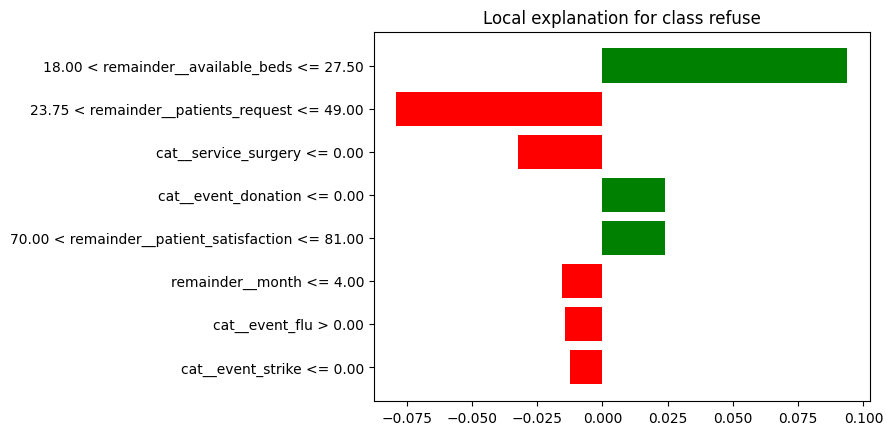

In [47]:
print("\n6. ИНТЕРПРЕТАЦИЯ МОДЕЛИ")

print("\n=== НАСТРОЙКА LIME ДЛЯ ЛОКАЛЬНОЙ ИНТЕРПРЕТАЦИИ ===")

X_train_trans = preprocessor.transform(X_train)

feature_names = preprocessor.get_feature_names_out()

category_names = ['no_refuse','refuse']

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_trans,
    feature_names=feature_names,
    class_names=category_names,
    mode='classification',
    random_state=RANDOM_STATE
)

print("=== НАСТРОЙКА SHAP ДЛЯ ГЛОБАЛЬНОЙ ИНТЕРПРЕТАЦИИ ===")
X_test_trans = preprocessor.transform(X_val)
clf = best_model.named_steps['clf']
exp = explainer_lime.explain_instance(X_test_trans[i], clf.predict_proba, num_features=8, top_labels=1)
print('Original row (raw):')
print(X_val.iloc[i])
print('\nLIME explanation (label=refuse):')
print(exp.as_list(label=1))
fig = exp.as_pyplot_figure()

# SHAP

Top 10 SHAP features:
remainder__patients_request 0.3207
remainder__available_beds 0.1262
remainder__patients_admitted 0.0039
remainder__week 0.0031
remainder__patient_satisfaction 0.003
remainder__staff_morale 0.0012
remainder__month 0.0011
cat__event_flu 0.0006
cat__service_emergency 0.0006
cat__service_surgery 0.0002


C:\Users\Ivan\AppData\Local\Temp\ipykernel_13908\3255168018.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_class1, X_train_trans, feature_names=feature_names, show=False)


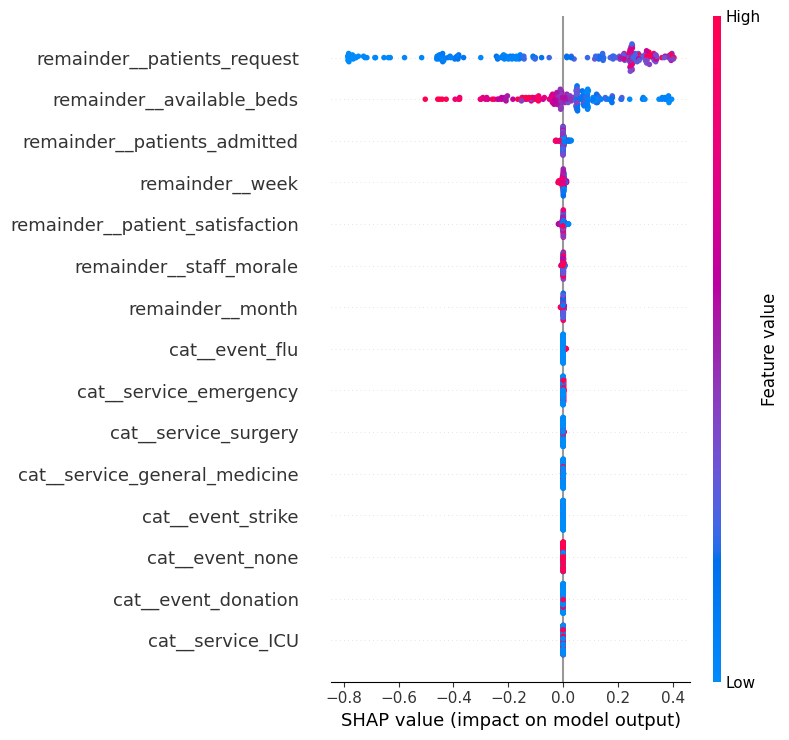

C:\Users\Ivan\AppData\Local\Temp\ipykernel_13908\3255168018.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_class1, X_train_trans, feature_names=feature_names,


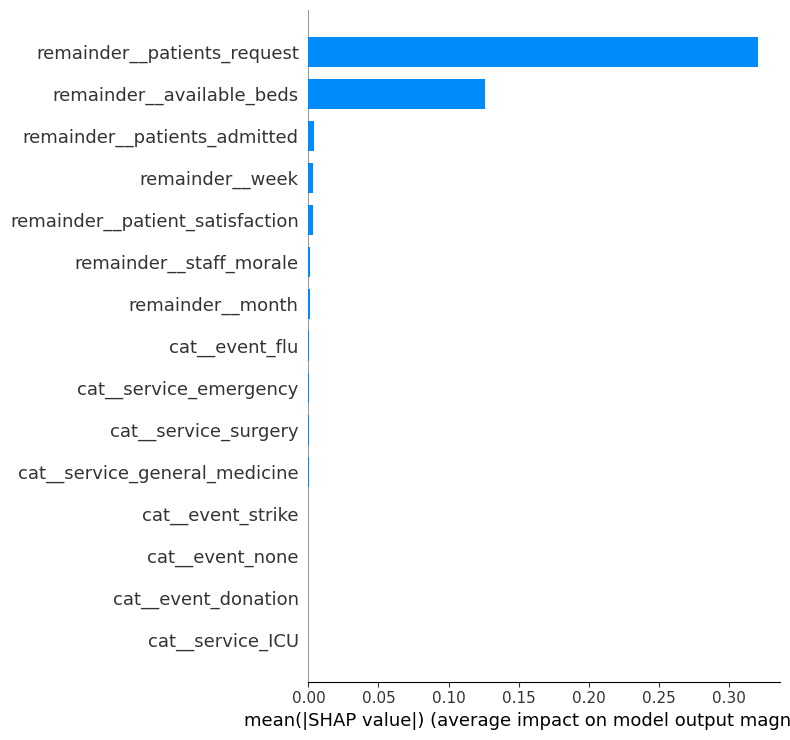

In [48]:
X_train_trans = preprocessor.transform(X_train)
X_train_trans = np.asarray(X_train_trans)

explainer = shap.Explainer(clf, X_train_trans)

shap_vals = explainer(X_train_trans)

shap_class1 = shap_vals.values[..., 1]

mean_abs = np.mean(np.abs(shap_class1), axis=0)  
feat_imp = sorted(zip(feature_names, mean_abs), key=lambda x: x[1], reverse=True)

print("Top 10 SHAP features:")
for f, v in feat_imp[:10]:
    print(f, round(v, 4))

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_class1, X_train_trans, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_class1, X_train_trans, feature_names=feature_names,
                  plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# Заключение


7. ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ


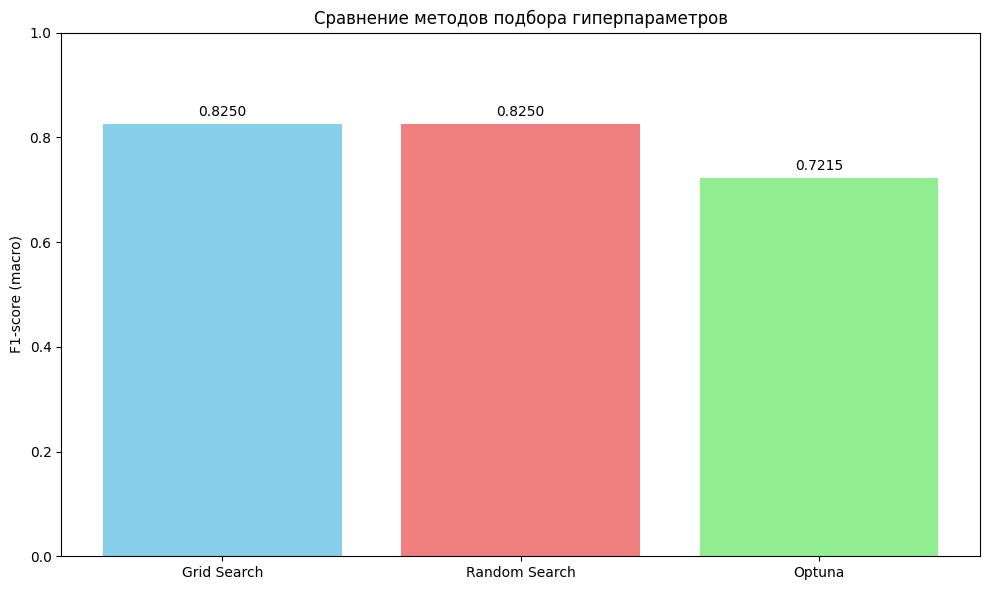

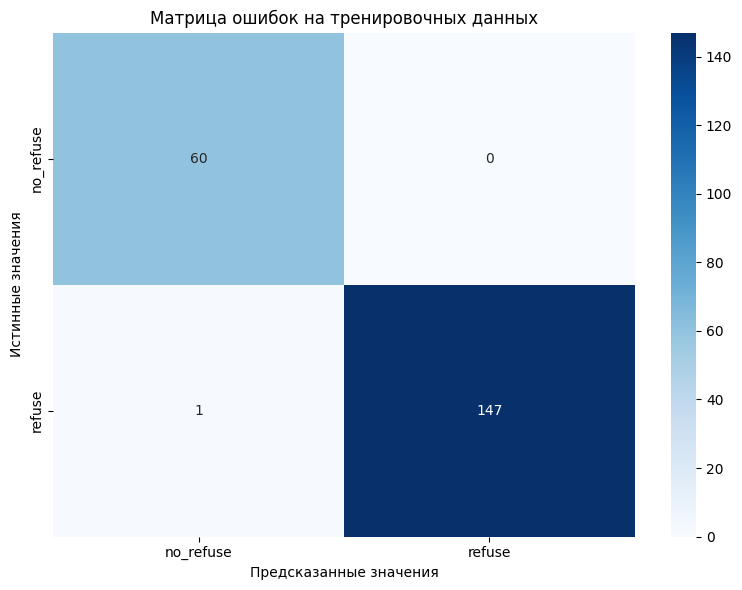

In [49]:
print("\n7. ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")

plt.figure(figsize=(10, 6))
methods = list(methods_comparison.keys())
scores = list(methods_comparison.values())
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars = plt.bar(methods, scores, color=colors)

plt.title('Сравнение методов подбора гиперпараметров')
plt.ylabel('F1-score (macro)')
plt.ylim(0, 1)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{scores[i]:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[category_names[i] for i in range(2)],
            yticklabels=[category_names[i] for i in range(2)])
plt.title('Матрица ошибок на тренировочных данных')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Итоги

В этой лабораторной работе была обучена и настроена модель RandomForest (сравнивали GridSearch, RandomizedSearch и Optuna). 
Различие методов — стратегия поиска (перебор, случайный поиск, байесовская/интеллектуальная оптимизация). Это дало возможность сравнить эффективность методов и устойчивость найденных параметров. Данные из датасета были подготовлены и разделены на обучающую и тестовую выборки.

По тестовой выборке лучшую точность показал GridSearch (≈ 0.881), RandomizedSearch — ≈ 0.857, Optuna — ≈ 0.810; 

Для объяснения решений использованы локально LIME (поясняет отдельные строки — стохастичен) и глобально SHAP (стабильный, показывает среднее влияние признаков). 

LIME удобен для объяснения отдельных примеров (показать «почему модель отказала именно в эту неделю»).

SHAP показал, что основные драйверы модели — patients_request и available_beds; остальные признаки вносят гораздо меньший вклад. 

SHAP даёт стабильную и количественную картину значимости признаков для всей модели.